In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel
import trimesh
from scipy.ndimage import rotate
import os
import json

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Define paths to the JSON files
train_split_path = r"C:\dev\ML\3DModelGen\Shapenet\train_split.json"
val_split_path = r"C:\dev\ML\3DModelGen\Shapenet\val_split.json"
test_split_path = r"C:\dev\ML\3DModelGen\Shapenet\test_split.json"

# Load the JSON files
with open(train_split_path, 'r') as f:
    train_data = json.load(f)

with open(val_split_path, 'r') as f:
    val_data = json.load(f)

with open(test_split_path, 'r') as f:
    test_data = json.load(f)

In [4]:
val_data

[[0, 'Airplane', '02691156/points/be02fd401a12d23822362be7f5226e91.npy'],
 [4, 'Chair', '03001627/points/c983108db7fcfa3619fb4103277a6b93.npy'],
 [15, 'Table', '04379243/points/6ef4f1f0b3f8aad48cbb8bac2032149c.npy'],
 [3, 'Car', '02958343/points/a495bebb2ebd72f3dd7cb6e3ad90d3ea.npy'],
 [0, 'Airplane', '02691156/points/1b7ac690067010e26b7bd17e458d0dcb.npy'],
 [0, 'Airplane', '02691156/points/35c9e363ca3fa6f8e4fc4c6009ee9462.npy'],
 [8, 'Lamp', '03636649/points/d54d7977d760f4c3bd16d4490a10a752.npy'],
 [0, 'Airplane', '02691156/points/7e1d4583f70c8583431589819e5ca60c.npy'],
 [4, 'Chair', '03001627/points/39fb5d3f557f64d4389f9a01d027a78.npy'],
 [15, 'Table', '04379243/points/366645cdaab60c793e5eb583c9d92b57.npy'],
 [15, 'Table', '04379243/points/57e4a4a4806c38e33702d3e624608075.npy'],
 [15, 'Table', '04379243/points/5317439efc03a22de27790b0ec8671f7.npy'],
 [15, 'Table', '04379243/points/1e202e618d6375052945e400e1430726.npy'],
 [15, 'Table', '04379243/points/f65decafeb2b8518dcfcef693e7ec696

In [5]:
# Preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

# Encode text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_text(tokens):
    return tokenizer(tokens, is_split_into_words=True, return_tensors='pt', padding='max_length', truncation=True)

# Preprocess 3D model
def preprocess_3d_model(filepath, max_points=4096):
    model = np.load(filepath)
    if model.shape[0] > max_points:
        model = model[:max_points]
    else:
        padding = max_points - model.shape[0]
        model = np.pad(model, ((0, padding), (0, 0)), mode='constant', constant_values=0)
    return model.astype(np.float32)

# Custom dataset class
class Text3DDataset(Dataset):
    def __init__(self, data, root_dir, max_points=4096):
        self.data = data
        self.root_dir = root_dir
        self.max_points = max_points
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        text_description = item[1]
        model_path = os.path.join(self.root_dir, item[2])
        
        text_encoded = encode_text(preprocess_text(text_description))
        model_processed = preprocess_3d_model(model_path, max_points=self.max_points)
        
        return text_encoded, model_processed



c:\Users\Dell\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
def custom_collate_fn(batch):
    text_batch = {'input_ids': [], 'attention_mask': []}
    model_batch = []

    for item in batch:
        text_encoded, model_processed = item
        text_batch['input_ids'].append(text_encoded['input_ids'].squeeze(0))
        text_batch['attention_mask'].append(text_encoded['attention_mask'].squeeze(0))
        model_batch.append(torch.tensor(model_processed))
    
    text_batch['input_ids'] = torch.stack(text_batch['input_ids'])
    text_batch['attention_mask'] = torch.stack(text_batch['attention_mask'])
    model_batch = torch.stack(model_batch)

    return text_batch, model_batch


In [7]:
# Root directory for the ShapeNet data
root_dir = 'ShapeNet/'

# Create datasets
train_dataset = Text3DDataset(train_data, root_dir)
val_dataset = Text3DDataset(val_data, root_dir)
test_dataset = Text3DDataset(test_data, root_dir)

# Create dataloaders
# Create dataloaders with custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)


In [8]:
class Generator(nn.Module):
    def __init__(self, text_embedding_dim, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(text_embedding_dim + latent_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, output_dim),
        )
    
    def forward(self, z):
        output = self.model(z)
        return output.view(output.size(0), -1, 3)

# Example dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
text_embedding_dim = 256
latent_dim = 128
max_points = 4096
output_dim = max_points * 3  # 4096 points, each with 3 coordinates

generator = Generator(text_embedding_dim, latent_dim, output_dim).to(device)


In [9]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size, text_embedding_dim)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # [CLS] token's output
        return self.fc(pooled_output)

text_encoder = TextEncoder().to(device)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.model(x)

input_dim = max_points * 3  # Same as the generator's output dimension
discriminator = Discriminator(input_dim).to(device)


In [11]:
# Hyperparameters

lr = 0.0002
epochs = 1

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

In [12]:
# Training loop
for epoch in range(epochs):
    for i, (text_batch, model_batch) in enumerate(train_dataloader):
        valid = torch.ones((text_batch['input_ids'].size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((text_batch['input_ids'].size(0), 1), requires_grad=False).to(device)
        
        real_models = model_batch.to(device)
        
        # Train Generator
        optimizer_G.zero_grad()
        
        text_embeddings = text_encoder(text_batch['input_ids'].to(device), text_batch['attention_mask'].to(device))
        z = torch.randn(text_batch['input_ids'].size(0), latent_dim).to(device)
        gen_input = torch.cat((text_embeddings, z), -1)
        gen_models = generator(gen_input)
        
        g_loss = adversarial_loss(discriminator(gen_models), valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        # Train Discriminator
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(discriminator(real_models), valid)
        fake_loss = adversarial_loss(discriminator(gen_models.detach()), fake)
        
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        # Print progress
        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


c:\Users\Dell\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


[Epoch 0/1] [Batch 0/6069] [D loss: 0.6944111585617065] [G loss: 0.6812934875488281]
[Epoch 0/1] [Batch 1/6069] [D loss: 0.685701847076416] [G loss: 0.7016097903251648]
[Epoch 0/1] [Batch 2/6069] [D loss: 0.6741204261779785] [G loss: 0.7174395322799683]
[Epoch 0/1] [Batch 3/6069] [D loss: 0.6653487682342529] [G loss: 0.730032205581665]
[Epoch 0/1] [Batch 4/6069] [D loss: 0.675148606300354] [G loss: 0.7324345111846924]
[Epoch 0/1] [Batch 5/6069] [D loss: 0.6502260565757751] [G loss: 0.7319430112838745]
[Epoch 0/1] [Batch 6/6069] [D loss: 0.6772814989089966] [G loss: 0.7239725589752197]
[Epoch 0/1] [Batch 7/6069] [D loss: 0.6886551380157471] [G loss: 0.6958054304122925]
[Epoch 0/1] [Batch 8/6069] [D loss: 0.6530540585517883] [G loss: 0.7036613821983337]
[Epoch 0/1] [Batch 9/6069] [D loss: 0.6246776580810547] [G loss: 0.6892895698547363]
[Epoch 0/1] [Batch 10/6069] [D loss: 0.6482905745506287] [G loss: 0.6907572150230408]
[Epoch 0/1] [Batch 11/6069] [D loss: 0.6686320304870605] [G loss: 0

In [18]:
# Save the trained models
torch.save(text_encoder.state_dict(), 'text_encoder.pth')
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


In [9]:
# Load trained models
text_encoder = TextEncoder().to(device)
text_encoder.load_state_dict(torch.load('text_encoder.pth'))
generator = Generator(text_embedding_dim, latent_dim, output_dim).to(device)
generator.load_state_dict(torch.load('generator.pth'))
discriminator = Discriminator(output_dim).to(device)
discriminator.load_state_dict(torch.load('discriminator.pth'))

text_encoder.eval()
generator.eval()
discriminator.eval()


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [10]:
def preprocess_and_encode_text(text):
    preprocessed_text = preprocess_text(text)
    encoded_text = encode_text(preprocessed_text)
    return encoded_text

In [13]:
import torch
import numpy as np
import trimesh

# Assuming the necessary modules and models (tokenizer, text_encoder, generator) are already defined and loaded

# Example input text preprocessing function
def preprocess_and_encode_text(text):
    encoded = tokenizer.encode_plus(
        text, 
        add_special_tokens=True, 
        max_length=128, 
        return_token_type_ids=False, 
        padding='max_length', 
        return_attention_mask=True, 
        return_tensors='pt',
    )
    return encoded

# Function to visualize a point cloud using trimesh
def visualize_point_cloud(points):
    point_cloud = trimesh.PointCloud(points)
    point_cloud.show()

# Function to create a voxel grid from a point cloud
def point_cloud_to_voxel_grid(points, voxel_size=0.05):
    min_coords = points.min(axis=0)
    max_coords = points.max(axis=0)
    grid_shape = np.ceil((max_coords - min_coords) / voxel_size).astype(int)
    voxel_grid = np.zeros(grid_shape, dtype=bool)
    
    indices = np.floor((points - min_coords) / voxel_size).astype(int)
    voxel_grid[indices[:, 0], indices[:, 1], indices[:, 2]] = True
    
    return voxel_grid

# Example input text
input_text = "Guitar"
encoded_text = preprocess_and_encode_text(input_text)

input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

# Print encoded text information
print("Input IDs:", input_ids)
print("Attention Mask:", attention_mask)

# Generate text embeddings using the text encoder
with torch.no_grad():
    text_embeddings = text_encoder(input_ids, attention_mask)

print("Text Embeddings Shape:", text_embeddings.shape)
#print("Text Embeddings:", text_embeddings)

# Create a random noise vector
z = torch.randn(text_embeddings.size(0), latent_dim).to(device)
gen_input = torch.cat((text_embeddings, z), -1)

# Generate the 3D model
with torch.no_grad():
    gen_model = generator(gen_input)

gen_model_np = gen_model.cpu().numpy()

print("Generated Model Shape:", gen_model_np.shape)
print("Generated Model:", gen_model_np)

# Visualize the generated 3D model as a point cloud
visualize_point_cloud(gen_model_np[0])

# Convert to voxel grid and visualize
voxel_grid = point_cloud_to_voxel_grid(gen_model_np[0], voxel_size=0.05)

if len(voxel_grid.shape) == 3:
    voxel_centers = np.argwhere(voxel_grid)
    voxel_centers = voxel_centers * 0.05  # Adjust according to your voxel size
    mesh = trimesh.voxel.ops.multibox(voxel_centers, pitch=0.05)
    mesh.show()
else:
    print("Error: Voxel grid is not 3D.")


Input IDs: tensor([[ 101, 2858,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0')
Attention Mask: tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

In [36]:
type(gen_model_np)

numpy.ndarray

In [53]:
gen_model_np[0].shape

(4096, 3)

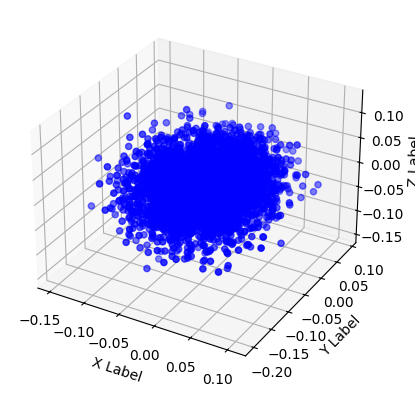

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random point cloud data
point_cloud = gen_model_np

# Extract the 4096 points from the point cloud
points = point_cloud[0]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o')

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()